# Class code for Comparison Study of Outlier Detection
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

|Method|Category|JIT Enabled|Multicore|cited|
|:--|:--:|:--:|:--:|:--:|
|LOF (Breunig et al., 2000)|Proximity|No|Yes||
|kNN (Ramaswamy et al., 2000)|Proximity|No|Yes||
|AvgkNN (Angiulli and Pizzuti, 2002)|Proximity|No|Yes||
|CBLOF (He et al., 2003)|Proximity|Yes|No||
|OCSVM (Sch ̈olkopf et al., 2001)|Linear Model|No|No||
|LOCI (Papadimitriou et al., 2003)|Proximity|Yes|No|1157|
|PCA (Shyu et al., 2003)|Linear Model|No|No||
|MCD (Hardin and Rocke, 2004)|Linear Model|No|No||
|Feature Bagging (Lazarevic and Kumar, 2005)|Ensembling|No|Yes|705|
|ABOD (Kriegel et al., 2008)|Proximity|Yes|No|884|
|Isolation Forest (Liu et al., 2008)|Ensembling|No|Yes||
|HBOS (Goldstein and Dengel, 2012)|Proximity|Yes|No||
|SOS (Janssens et al., 2012)|Proximity|Yes|No||
|AutoEncoder (Sakurada and Yairi, 2014)|Neural Net|Yes|No||
|AOM (Aggarwal and Sathe, 2015)|Ensembling|No|No||
|MOA (Aggarwal and Sathe, 2015)|Ensembling|No|No||
|SO-GAAL (Liu et al., 2019)|Neural Net|No|No||
|MO-GAAL (Liu et al., 2019)|Neural Net|No|No||
|XGBOD (Zhao and Hryniewicki, 2018b)|Ensembling|No|Yes|93|
|LSCP (Zhao et al., 2019)|Ensembling|No|No|97|

## Import

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.graph_objects as go
from IPython.display import HTML

import plotly.express as px

from sklearn.covariance import EmpiricalCovariance, MinCovDet

from alibi_detect.od import IForest
# from pyod.models.iforest import IForest

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
import seaborn as sns

from PyNomaly import loop

from sklearn import svm

from loci.loci import run_loci

from pyod.models.lscp import LSCP
from pyod.models.hbos import HBOS

from pyod.models.so_gaal import SO_GAAL
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.xgbod import XGBOD

from pyod.models.feature_bagging import FeatureBagging
from pyod.models.sos import SOS
from pyod.models.auto_encoder import AutoEncoder

## EbayesThresh

In [2]:
%load_ext rpy2.ipython

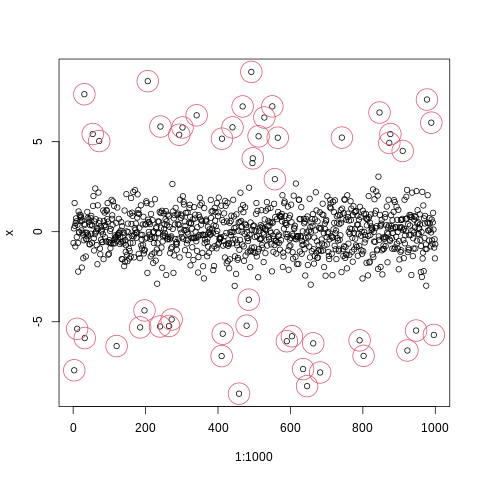

In [3]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-7,-5), runif(25,5,7), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
index_of_trueoutlier
x=signal+epsilon
plot(1:1000,x)
points(index_of_trueoutlier,x[index_of_trueoutlier],col=2,cex=4)

#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [4]:
%R -o x
%R -o index_of_trueoutlier
%R -o signal

In [5]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [6]:
xhat = np.array(ebayesthresh(FloatVector(x)))

In [7]:
# plt.plot(x)
# plt.plot(xhat)

In [8]:
outlier_true_index = index_of_trueoutlier

In [9]:
outlier_true_value = x[index_of_trueoutlier]

package와 비교를 위해 outlier는 -1, inlier는 1로 표시

In [10]:
outlier_true_one = signal.copy()

In [11]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

## Class Code

In [84]:
class Conf_matrx:
    def conf(self,original,compare):
        self.conf_matrix = confusion_matrix(original, compare)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        for i in range(self.conf_matrix.shape[0]):
            for j in range(self.conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        print('Accuracy: %.3f' % accuracy_score(original, compare))
        print('Precision: %.3f' % precision_score(original, compare))
        print('Recall: %.3f' % recall_score(original, compare))
        print('F1 Score: %.3f' % f1_score(original, compare))

In [101]:
class Linear:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=20): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

## Linear

In [54]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [167]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal_1 = sample(c(runif(25,-6,-1), runif(25,1,6), rep(0,950)))
index_of_trueoutlier_1 = which(signal_1!=0)
index_of_trueoutlier_1
x_1=signal_1+epsilon

In [168]:
%R -o x_1
%R -o index_of_trueoutlier_1
%R -o signal_1

In [169]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [170]:
outlier_true_index_1 = index_of_trueoutlier_1

In [171]:
outlier_true_value_1 = x_1[index_of_trueoutlier_1]

In [172]:
outlier_true_one_1 = signal.copy()

In [173]:
outlier_true_one_1 = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one_1))

In [174]:
_x_1 = np.linspace(0,2,1000)
_y1_1 = 5*_x_1
_y_1 = _y1_1 + x_1 # x is epsilon

In [175]:
_df=pd.DataFrame({'x':_x_1, 'y':_y_1})

In [176]:
X = np.array(_df)

### GODE

In [177]:
w=np.zeros((1000,1000))

In [178]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [179]:
_Linear = Linear(_df)

In [180]:
_Linear.fit(sd=20)

In [181]:
outlier_simul_one = (_Linear.df['Residual']**2).tolist()

In [182]:
outlier_simul_one = list(map(lambda x: -1 if x > 2 else 1,outlier_simul_one))

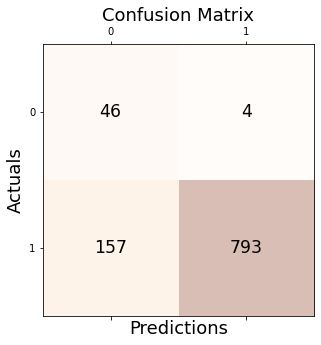

Accuracy: 0.839
Precision: 0.995
Recall: 0.835
F1 Score: 0.908


In [183]:
_conf = Conf_matrx().conf(outlier_true_one_1,outlier_simul_one)

### LOF

In [184]:
clf = LocalOutlierFactor(n_neighbors=2)

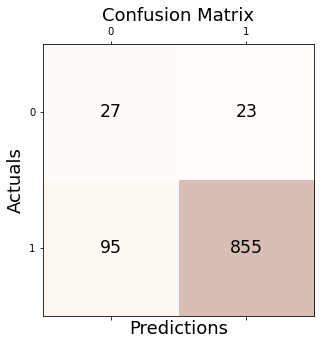

Accuracy: 0.882
Precision: 0.974
Recall: 0.900
F1 Score: 0.935


In [185]:
_conf = Conf_matrx().conf(outlier_true_one_1,clf.fit_predict(X))

### KNN

In [186]:
clf = KNN()
clf.fit(_df[['x', 'y']])
_df['knn_Clf'] = clf.labels_

In [187]:
outlier_KNN_one = list(clf.labels_)

In [188]:
outlier_KNN_one = list(map(lambda x: 1 if x==0  else -1,outlier_KNN_one))

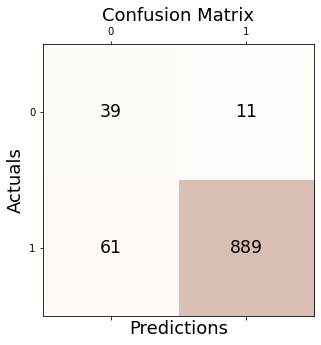

Accuracy: 0.928
Precision: 0.988
Recall: 0.936
F1 Score: 0.961


In [189]:
Conf_matrx().conf(outlier_true_one_1,outlier_KNN_one)

### CBLOF

In [190]:
clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
clf.fit(_df[['x', 'y']])
_df['CBLOF_Clf'] = clf.labels_

In [191]:
outlier_CBLOF_one = list(clf.labels_)

In [192]:
outlier_CBLOF_one = list(map(lambda x: 1 if x==0  else -1,outlier_CBLOF_one))

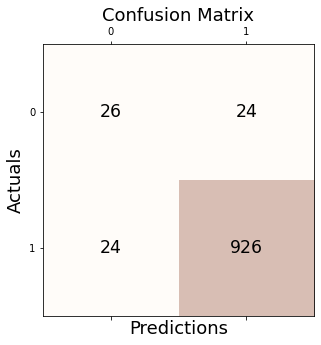

Accuracy: 0.952
Precision: 0.975
Recall: 0.975
F1 Score: 0.975


In [193]:
Conf_matrx().conf(outlier_true_one_1,outlier_CBLOF_one)

### OCSVM

In [194]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [195]:
clf.fit(X)

OneClassSVM(gamma=0.1, nu=0.1)

In [196]:
outlier_OSVM_one = list(clf.predict(X))

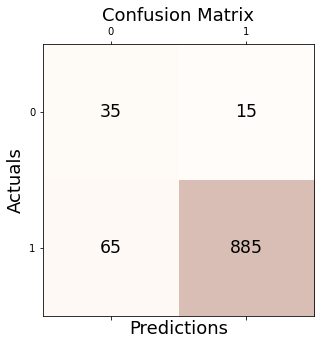

Accuracy: 0.920
Precision: 0.983
Recall: 0.932
F1 Score: 0.957


In [197]:
Conf_matrx().conf(outlier_true_one_1,outlier_OSVM_one)

### MCD

In [199]:
clf = MCD()
clf.fit(_df[['x', 'y']])
_df['MCD_clf'] = clf.labels_

In [202]:
outlier_MCD_one = list(clf.labels_)

In [203]:
outlier_MCD_one = list(map(lambda x: 1 if x==0  else -1,outlier_MCD_one))

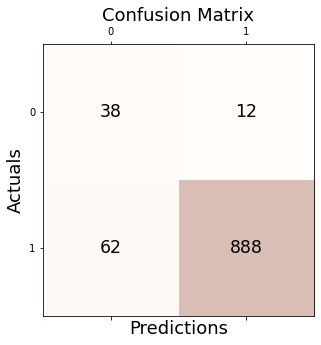

Accuracy: 0.926
Precision: 0.987
Recall: 0.935
F1 Score: 0.960


In [204]:
Conf_matrx().conf(outlier_true_one_1,outlier_MCD_one)

### Feature Bagging

In [205]:
clf = FeatureBagging()
clf.fit(_df[['x', 'y']])
_df['FeatureBagging_clf'] = clf.labels_

In [206]:
outlier_FeatureBagging_one = list(clf.labels_)

In [207]:
outlier_FeatureBagging_one = list(map(lambda x: 1 if x==0  else -1,outlier_FeatureBagging_one))

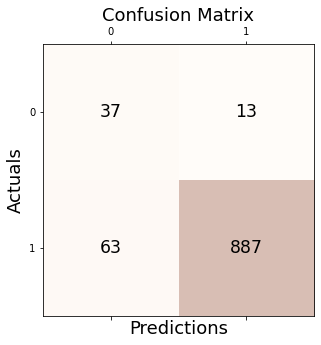

Accuracy: 0.924
Precision: 0.986
Recall: 0.934
F1 Score: 0.959


In [208]:
Conf_matrx().conf(outlier_true_one_1,outlier_FeatureBagging_one)

### ABOD

In [209]:
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = clf.labels_

In [210]:
outlier_ABOD_one = list(clf.labels_)

In [211]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

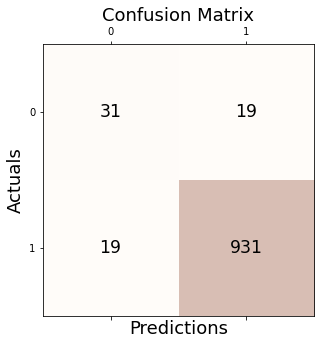

Accuracy: 0.962
Precision: 0.980
Recall: 0.980
F1 Score: 0.980


In [212]:
Conf_matrx().conf(outlier_true_one_1,outlier_ABOD_one)

### IForest

In [213]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [214]:
od.fit(_df[['x', 'y']])

In [215]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

In [216]:
_df['IF_alibi'] = preds['data']['is_outlier']

In [217]:
outlier_alibi_one = _df['IF_alibi']

In [218]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

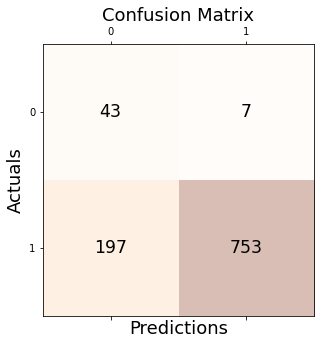

Accuracy: 0.796
Precision: 0.991
Recall: 0.793
F1 Score: 0.881


In [219]:
Conf_matrx().conf(outlier_true_one_1,outlier_alibi_one)

### HBOS

In [221]:
clf = HBOS()
clf.fit(_df[['x', 'y']])
_df['HBOS_clf'] = clf.labels_

In [222]:
outlier_HBOS_one = list(clf.labels_)

In [223]:
outlier_HBOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_HBOS_one))

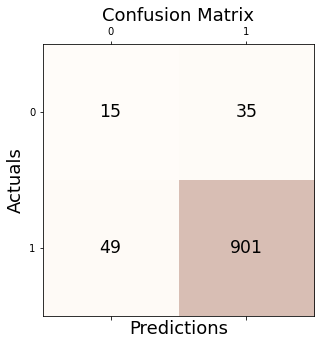

Accuracy: 0.916
Precision: 0.963
Recall: 0.948
F1 Score: 0.955


In [224]:
Conf_matrx().conf(outlier_true_one_1,outlier_HBOS_one)

### SOS

In [227]:
clf = SOS()
clf.fit(_df[['x', 'y']])
_df['SOS_clf'] = clf.labels_

In [228]:
outlier_SOS_one = list(clf.labels_)

In [229]:
outlier_SOS_one = list(map(lambda x: 1 if x==0  else -1,outlier_SOS_one))

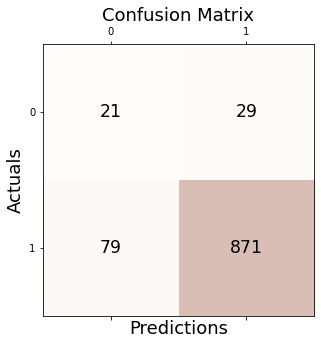

Accuracy: 0.892
Precision: 0.968
Recall: 0.917
F1 Score: 0.942


In [230]:
Conf_matrx().conf(outlier_true_one_1,outlier_SOS_one)

### AutoEncoder

In [237]:
clf = AutoEncoder()

In [238]:
clf.fit(X)

ValueError: The number of neurons should not exceed the number of features

In [196]:
outlier_OSVM_one = list(clf.predict(X))

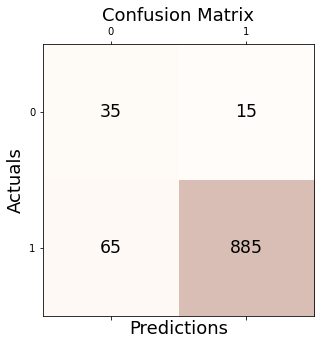

Accuracy: 0.920
Precision: 0.983
Recall: 0.932
F1 Score: 0.957


In [197]:
Conf_matrx().conf(outlier_true_one_1,outlier_OSVM_one)

### 7. SO_GAAL

In [496]:
SO_GAAL_clf = SO_GAAL()
SO_GAAL_clf.fit(_df[['x', 'y']])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

SO_GAAL(contamination=0.1, decay=1e-06, lr_d=0.01, lr_g=0.0001, momentum=0.9,
    stop_epochs=20)

In [497]:
_df['SO_GAAL_clf'] = SO_GAAL_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

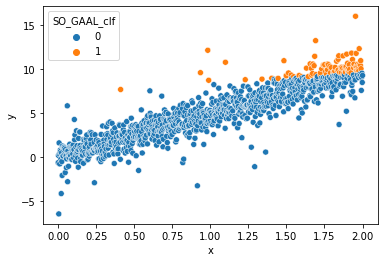

In [498]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'SO_GAAL_clf')

In [499]:
outlier_SO_GAAL_clf_one = list(SO_GAAL_clf.labels_)

In [500]:
outlier_SO_GAAL_clf_one = list(map(lambda x: 1 if x==0  else -1,outlier_SO_GAAL_clf_one))

In [501]:
conf_matrix = confusion_matrix(outlier_true_one_1, outlier_SO_GAAL_clf_one)

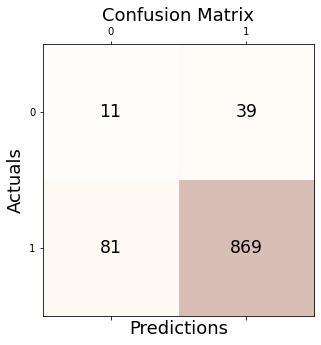

In [502]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [503]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_1, outlier_SO_GAAL_clf_one))
print('Precision: %.3f' % precision_score(outlier_true_one_1, outlier_SO_GAAL_clf_one))
print('Recall: %.3f' % recall_score(outlier_true_one_1, outlier_SO_GAAL_clf_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_1, outlier_SO_GAAL_clf_one))

Accuracy: 0.880
Precision: 0.957
Recall: 0.915
F1 Score: 0.935


### 9. MO_GAAL

In [512]:
MO_GAAL_clf = MO_GAAL()
MO_GAAL_clf.fit(_df[['x', 'y']])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

MO_GAAL(contamination=0.1, decay=1e-06, k=10, lr_d=0.01, lr_g=0.0001,
    momentum=0.9, stop_epochs=20)

In [513]:
_df['MO_GAAL_clf'] = MO_GAAL_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

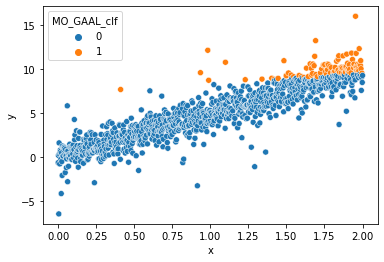

In [514]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'MO_GAAL_clf')

In [515]:
outlier_MO_GAAL_clf_one = list(MO_GAAL_clf.labels_)

In [516]:
outlier_MO_GAAL_clf_one = list(map(lambda x: 1 if x==0  else -1,outlier_MO_GAAL_clf_one))

In [517]:
conf_matrix = confusion_matrix(outlier_true_one_1, outlier_MO_GAAL_clf_one)

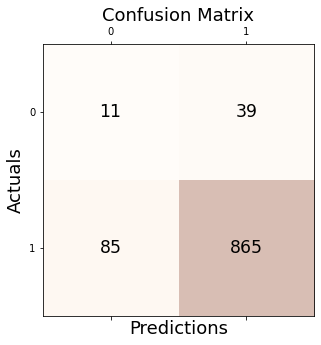

In [518]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [519]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_1, outlier_MO_GAAL_clf_one))
print('Precision: %.3f' % precision_score(outlier_true_one_1, outlier_MO_GAAL_clf_one))
print('Recall: %.3f' % recall_score(outlier_true_one_1, outlier_MO_GAAL_clf_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_1, outlier_MO_GAAL_clf_one))

Accuracy: 0.876
Precision: 0.957
Recall: 0.911
F1 Score: 0.933


### 10. LSCP

In [529]:
detectors = [KNN(), LOF(), OCSVM()]

In [530]:
LSCP_clf = LSCP(detectors)

In [531]:
LSCP_clf.fit(_df[['x', 'y']])

/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(


LSCP(contamination=0.1,
   detector_list=[KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2), OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)],
   local_max_features=1.0, local_region_size=30, n_bins=3,
   random_state=RandomState(MT19937) at 0x7F4F53335B40)

In [532]:
_df['LSCP_clf'] = LSCP_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

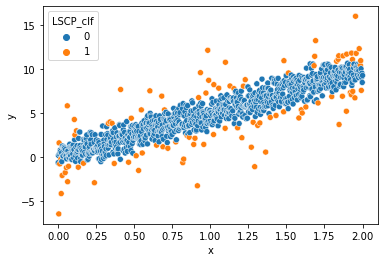

In [533]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'LSCP_clf')

In [534]:
outlier_LSCP_one = list(LSCP_clf.labels_)

In [535]:
outlier_LSCP_one = list(map(lambda x: 1 if x==0  else -1,outlier_LSCP_one))

In [536]:
conf_matrix = confusion_matrix(outlier_true_one_1, outlier_LSCP_one)

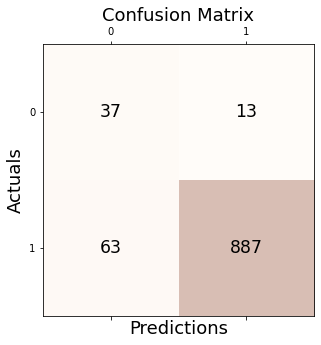

In [537]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [538]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_1, outlier_LSCP_one))
print('Precision: %.3f' % precision_score(outlier_true_one_1, outlier_LSCP_one))
print('Recall: %.3f' % recall_score(outlier_true_one_1, outlier_LSCP_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_1, outlier_LSCP_one))

Accuracy: 0.924
Precision: 0.986
Recall: 0.934
F1 Score: 0.959
